# Set up virtual machine

In [ ]:
# check environment is built with cuda
import tensorflow as tf
print('Built with cuda = ', tf.test.is_built_with_cuda(), '\n'
      'tf version = ', tf.__version__, '\n'
      'run on gpu = ', tf.config.list_physical_devices('GPU'), '\n'
      'Num GPUs Available = ', len(tf.config.experimental.list_physical_devices('GPU')))

# AAPL, JPM 1-min data

In [2]:
%%time
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

# get the equity HF data (AAPL, JPM)
path = "D:\\data\\algoseek\\allfiles"
allFiles = glob.glob(os.path.join(path,"**\\*.csv.gz"))

np_array_list = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    np_array_list.append(df)

# Create a bit array, just in case an array is useful later
comb_np_array = np.vstack(np_array_list)

# Create dataframe, for visualization, etc.
bigF = pd.DataFrame(comb_np_array)

# Set column headings
bigF.columns = ["Date","Ticker","TimeBarStart","OpenBarTime","OpenBidPrice","OpenBidSize","OpenAskPrice","OpenAskSize","FirstTradeTime","FirstTradePrice","FirstTradeSize",
                     "HighBidTime","HighBidPrice","HighBidSize","HighAskTime","HighAskPrice","HighAskSize","HighTradeTime","HighTradePrice","HighTradeSize","LowBidTime","LowBidPrice",
                     "LowBidSize","LowAskTime","LowAskPrice","LowAskSize","LowTradeTime","LowTradePrice","LowTradeSize","CloseBarTime","CloseBidPrice","CloseBidSize","CloseAskPrice",
                     "CloseAskSize","LastTradeTime","LastTradePrice","LastTradeSize","MinSpread","MaxSpread","CancelSize","VolumeWeightPrice","NBBOQuoteCount","TradeAtBid","TradeAtBidMid",
                     "TradeAtMid","TradeAtMidAsk","TradeAtAsk","TradeAtCrossOrLocked","Volume","TotalTrades","FinraVolume","FinraVolumeWeightPrice","UptickVolume","DowntickVolume",
                     "RepeatUptickVolume","RepeatDowntickVolume","UnknownTickVolume","TradeToMidVolWeight","TradeToMidVolWeightRelative","TimeWeightBid","TimeWeightAsk"]

# Set a date-time index, using OpenBarTime
bigF['DateTimeIndex'] = pd.to_datetime(bigF['Date'].astype(str)) + pd.to_timedelta(bigF['OpenBarTime'].astype(str))
bigF = bigF.set_index('DateTimeIndex')

# Set datatypes and add separate Date and Time columns in case useful later
bigF['Ticker'] = bigF.Ticker.astype(str)
bigF['CloseBidSize'] = bigF.CloseBidSize.astype(float)
bigF['CloseAskSize'] = bigF.CloseAskSize.astype(float)
bigF['CloseBidPrice'] = bigF.CloseBidPrice.astype(float)
bigF['CloseAskPrice'] = bigF.CloseAskPrice.astype(float)

# Reduce bigF to smF
smF = bigF[['Ticker','CloseBidSize','CloseAskSize','CloseBidPrice','CloseAskPrice']].copy()   # NB: take copy
smF['Date'] = pd.to_datetime(bigF['Date'].astype(str))
smF['Time'] = pd.to_timedelta(bigF['OpenBarTime'].astype(str))
smF['DateTime'] = pd.to_datetime(bigF['Date'].astype(str)) + pd.to_timedelta(bigF['OpenBarTime'].astype(str))

# Compute WeightedMidPrice using the closing prices per analysis
smF['WeightedMidPrice'] = ((smF['CloseBidSize']*smF['CloseAskPrice']) + (smF['CloseAskSize']*smF['CloseBidPrice'])) / (smF['CloseBidSize'] + smF['CloseAskSize'])

# Raw returns
AAPL_rr = smF.loc[smF['Ticker'] == "AAPL"]
AAPL_rr = AAPL_rr['WeightedMidPrice'] - AAPL_rr['WeightedMidPrice'].shift(1)
AAPL_rr = AAPL_rr[AAPL_rr.notna()].copy()
AAPL_rr = AAPL_rr[AAPL_rr != 0].copy()
JPM_rr = smF.loc[smF['Ticker'] == "JPM"]
JPM_rr = JPM_rr['WeightedMidPrice'] - JPM_rr['WeightedMidPrice'].shift(1)
JPM_rr = JPM_rr[JPM_rr.notna()].copy()
JPM_rr = JPM_rr[JPM_rr != 0].copy()

# Log returns
AAPL_lr = smF.loc[smF['Ticker'] == "AAPL"]
AAPL_lr = np.log(AAPL_lr['WeightedMidPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()
JPM_lr = smF.loc[smF['Ticker'] == "JPM"]
JPM_lr = np.log(JPM_lr['WeightedMidPrice'].astype(float))
JPM_lr = JPM_lr - JPM_lr.shift(1)
JPM_lr = JPM_lr[JPM_lr.notna()].copy()
JPM_lr = JPM_lr[JPM_lr != 0].copy()

# Remove outliers
Q1l = AAPL_lr.quantile(0.001)   # Start with these quantile values, experiment with lower values
Q3l = AAPL_lr.quantile(0.999)   # Start with these quantile values, experiment with lower values if necessary
IQl = Q3l - Q1l
Q1r = AAPL_rr.quantile(0.001)   # Start with these quantile values, experiment with lower values
Q3r = AAPL_rr.quantile(0.999)   # Start with these quantile values, experiment with lower values if necessary
IQr = Q3r - Q1r
AAPL_lr = AAPL_lr[~((AAPL_lr < (Q1l - 1.5 * IQl)) | (AAPL_lr > (Q3l + 1.5 * IQl)))]
AAPL_rr = AAPL_rr[~((AAPL_rr < (Q1r - 1.5 * IQr)) | (AAPL_rr > (Q3r + 1.5 * IQr)))]
JPM_lr = JPM_lr[~((JPM_lr < (Q1l - 1.5 * IQl)) | (JPM_lr > (Q3l + 1.5 * IQl)))]
JPM_rr = JPM_rr[~((JPM_rr < (Q1r - 1.5 * IQr)) | (JPM_rr > (Q3r + 1.5 * IQr)))]

# for contruction of dataframes of log returns for use by neural networks
AAPL_df = AAPL_lr
JPM_df = JPM_lr

# log returns only for models split into estimate (E=60%) and out-of-forecast (F=40%)
AAPL = AAPL_lr.to_numpy(copy=True)
JPM = JPM_lr.to_numpy(copy=True)
aaplE = AAPL[0:269618,]
aaplF = AAPL[269618:,]
jpmE = JPM[0:200363,]
jpmF = JPM[200363:,]
aaplE = aaplE[:,np.newaxis]
aaplF = aaplF[:,np.newaxis]
jpmE = jpmE[:,np.newaxis]
jpmF = jpmF[:,np.newaxis]

# set dimension variables for LSTM
ALL_DATA = len(AAPL)
TRAIN_DATA = len(aaplE)
TEST_DATA = len(aaplF)

bigF.shape, AAPL_rr.shape, JPM_rr.shape, AAPL_lr.shape, JPM_lr.shape, aaplE.shape, aaplF.shape, jpmE.shape, jpmF.shape, ALL_DATA, TRAIN_DATA, TEST_DATA

Wall time: 34.7 s


((1079514, 61),
 (449389,),
 (334044,),
 (449363,),
 (333939,),
 (269618, 1),
 (179745, 1),
 (200363, 1),
 (133576, 1),
 449363,
 269618,
 179745)

# EURUSD 1-min, DEXJPUS daily, simulated data

In [ ]:
%%time
import os
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date

# NOTE: 02-Apr-2021 Not clear what happened to LSTM_03????
# from LSTM_03 import sim_msm_data

# Simulated data, 60% in-sample for estimation, 40% out-of-sample for forecasts
kbar = 4
b = 6
m0 = 1.6
gamma_kbar = 0.8
sig = 2/np.sqrt(252)    
T = 7087            
dat1 = sim_msm_data(b,m0,gamma_kbar,sig,kbar,T)
dat1E = dat1[0:4252,]
dat1F = dat1[4252:,]

# DEXJPUS, 60% in-sample for estimation, 40% out-of-sample for forecasts
dat2 = pd.read_csv("DEXJPUS.csv")                                   
dat2 = dat2.loc[dat2.DEXJPUS != "."].DEXJPUS.astype(float)
dat2 = np.array(dat2)
dat2_rtn = dat2[0:-1]
dat2 = np.log(dat2[1:])-np.log(dat2[0:-1])
dat2 = dat2[dat2 != 0]
dat2 = dat2[:,np.newaxis]
dat2E = dat2[0:4252,]
dat2F = dat2[4252:,]

# HF EURUSD data
dfFX = pd.read_csv(r"D:\data\histdata\ALL.csv", header=None)               # 2018, 2019, 202001, 202002, 202003 files combined in 'ALL'
dfFX.columns = ['date','time','barOpenBid', 'barHighBid', 'barLowBid', 'barCloseBid','volume']
totalEntries1y = dfFX.shape[0]

# Set a date-time index, using time
dfFX['DateTimeIndex'] = pd.to_datetime(dfFX['date'].astype(str)) + pd.to_timedelta(dfFX['time'].astype(str))
dfFX = dfFX.set_index('DateTimeIndex')

# Set datatypes and add separate Date and Time columns in case useful later
dfFX['barOpenBid'] = dfFX.barOpenBid.astype(float)
dfFX['barHighBid'] = dfFX.barHighBid.astype(float)
dfFX['barLowBid'] = dfFX.barLowBid.astype(float)
dfFX['barCloseBid'] = dfFX.barCloseBid.astype(float)
dfFX['volume'] = dfFX.volume.astype(float)

# Raw returns
rrFX = dfFX['barCloseBid'] - dfFX['barCloseBid'].shift(1)
rrFX = rrFX[rrFX.notna()].copy()
rrFX = rrFX[rrFX != 0].copy()

# log returns
lrFX = np.log(dfFX['barCloseBid'].astype(float))
lrFX = lrFX - lrFX.shift(1)
lrFX = lrFX[lrFX.notna()].copy()
lrFX = lrFX[lrFX != 0].copy()

# Remove outliers
Q1l = lrFX.quantile(0.0001)   # Start with these quantile values, experiment with lower values
Q3l = lrFX.quantile(0.9999)   # Start with these quantile values, experiment with lower values if necessary
IQl = Q3l - Q1l
Q1r = rrFX.quantile(0.0001)   # Start with these quantile values, experiment with lower values
Q3r = rrFX.quantile(0.9999)   # Start with these quantile values, experiment with lower values if necessary
IQr = Q3r - Q1r
lrFX = lrFX[~((lrFX < (Q1l - 1.5 * IQl)) | (lrFX > (Q3l + 1.5 * IQl)))]
rrFX = rrFX[~((rrFX < (Q1r - 1.5 * IQr)) | (rrFX > (Q3r + 1.5 * IQr)))]

# for contruction of dataframes of log returns for use by neural networks
FX_df = lrFX

# log returns only for models split into estimate (E=60%) and out-of-forecast (F=40%)
FX = lrFX.to_numpy(copy=True)
fxE = FX[0:457419,]
fxF = FX[457419:,]
fxE = fxE[:,np.newaxis]
fxF = fxF[:,np.newaxis]

dfFX.shape, rrFX.shape, lrFX.shape, fxE.shape, fxF.shape

# Model selection | `logRet`

> * Source | _[tensorflow tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)_
> * Port this section into Paper 2. Must be written in a manner that Laurent easily can relate to. Thus, econometric-paper-style.  
> * See how Gu, Kelly Xiu have done it.

## Setup

In [4]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (12, 6)
mpl.rcParams['axes.grid'] = False
sns.set(style="darkgrid")

### Define RSquared function

In [5]:
def rSquared(y_true, y_pred):
    SS_res =  tf.keras.backend.sum(tf.keras.backend.square( y_true-y_pred )) 
    SS_tot = tf.keras.backend.sum(tf.keras.backend.square( y_true - tf.keras.backend.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + tf.keras.backend.epsilon()) )

### Define MZ-Regression function

> * DO THIS DURING THE WRITE-UP. DO ANY OF THE PAPERS HAVE MZ REGRESSIONS?  IF NOT, WHY NOT?  MIGHT NOT BE APPLICABLE

In [6]:
# Code from DEMSM_03.py
    
    # MZ regressions of squared returns on forecasts  (X=pred, Y=true)   # WHY SQUARED RETURNS?
    # Y_mz = pd.DataFrame(Y_sim)
    # X_mz = pd.DataFrame(X_sim[:,1])
    # compare_df = pd.concat([Y_mz, X_mz], axis=1)
    # compare_df.columns = ['Y_mz', 'X_mz']
    # mz_reg = f'Y_mz ~ X_mz'
    # mz_result = sm.ols(mz_reg, data=compare_df).fit()
    # g_0 = mz_result.params[0]
    # g_1 = mz_result.params[1]

### Create data pipeline

**Select data | AAPL, JPM, or EURUSD**

In [7]:
# Choose data: AAPL, JPM, or EURUSD
# df = AAPL_df
df = JPM_df
# df = FX_df

df = df[:40000,]     # REDUCE DATASET SIZE FOR WORKING

df.shape

(40000,)

In [8]:
# Create dataframe
df = pd.DataFrame(df)

# Set column headings
df.columns = ["logRet"]

df.head()

,logRet
DateTimeIndex,
2018-01-02 04:39:00,-0.006747
2018-01-02 04:47:00,0.003098
2018-01-02 05:43:00,-0.003098
2018-01-02 05:45:00,0.003140
2018-01-02 06:11:00,-0.002118


### Split the data into train, validation, and test

We use a (70%, 20%, 10%) split for the training, validation, and test sets. Note the data is not being randomly shuffled before splitting. 

In [9]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

***
**Terminology** | `Labels` <br>

A label is the thing that we are predicting — the $y$ variable in simple linear regression, for example. The label in our case is the volatility of AAPL, $\hat \sigma$, and the realized volatility of AAPL, $\hat \sigma_{RV}$.
***

### Data windowing

Data windowing is the process of mapping data inputs to outputs, and in the process of doing so, establishing a 3-dimensional data structure that is required by typical neural network architectures.  The process is not dissimilar to the data cubing associated with tools like Cognos, QlikView, and ActivPivot.  Its similar in some ways to the way Excel creates a pivot table.

The models in this training will make a set of predictions of AAPL volatility based on a `window` of consecutive samples from the data.

The main features of the input windows are:

* The width (number of time steps) of the input and label windows
* The time offset between them.
* Which features are used as inputs, labels, or both.

The window also defines the characteristics of the single-output and multi-time-step predictions that we shall make.

> **ACTION |** Add diagrams and descriptive text per tutorial for `Data windowing`

In [10]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

*create the 2 windows shown in the diagrams*

In [11]:
w1 = WindowGenerator(input_width=60, label_width=1, shift=60,
                     label_columns=['logRet'])
w1

Total window size: 120
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [119]
Label column name(s): ['logRet']

In [12]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['logRet'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['logRet']

*Given a list consecutive inputs, the split_window method below converts them to a window of inputs and a window of labels.*

In [13]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

*To illustrate, I stack three slices, the length of the total window, using window 1 framework above*

In [14]:
# Stack three slices, the length of the total window:
example_window = tf.stack([np.array(train_df[:w1.total_window_size]),
                           np.array(train_df[100:100+w1.total_window_size]),
                           np.array(train_df[200:200+w1.total_window_size])])


example_inputs, example_labels = w1.split_window(example_window)

# print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'labels shape: {example_labels.shape}')

Window shape: (3, 120, 1)
Inputs shape: (3, 60, 1)
labels shape: (3, 1, 1)


*Visualize the split window*

In [15]:
w1.example = example_inputs, example_labels

In [16]:
def plot(self, model=None, plot_col='logRet', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 12))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', markerfacecolor = 'hotpink', color = 'darkslategrey', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='darkblue', label='Labels', c='hotpink', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='darkblue', label='Predictions',
                  color = 'cyan', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

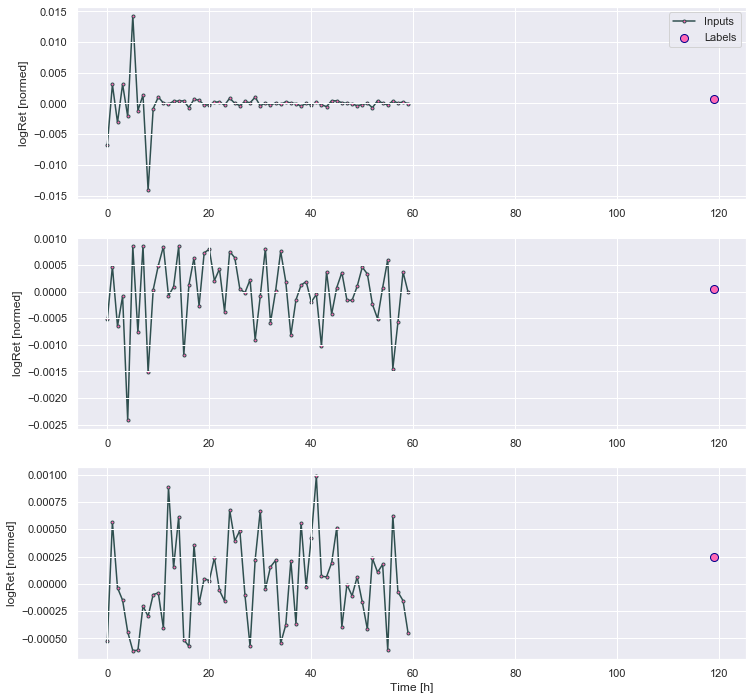

In [17]:
w1.plot()

### Transform the data

*Finally, I create a make_dataset method to take the time series and convert it, using to a tf.data.Dataset of (input_window, label_window) pairs using the preprocessing.timeseries_dataset_from_array function.*

In [18]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

*The WindowGenerator object holds training, validation and test data.  I add properties for accessing them as tf.data.Datasets using my make_dataset method above.*

In [19]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

*I use the WindowGenerator object to access to the tf.data.Dataset objects, in order to easily iterate over the data. The Dataset.element_spec property indicates the structure, dtypes and shapes of the dataset elements.*

In [20]:
# Each element is an (inputs, label) pair
w1.train.element_spec

(TensorSpec(shape=(None, 60, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

*I may iterate over our dataset, yielding concrete batches*

In [21]:
for example_inputs, example_labels in w1.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 60, 1)
Labels shape (batch, time, features): (32, 1, 1)


## 1-step prediction models

The simplest model we can build for time series data is one that predicts the time series future value, 1 timestep (1 minute in our case) in the future, based only on the current conditions.

I therefore start by building models to predict the log return, $\log{r_{t+1}}$, the time series `logRet`, 1 minute into the future.

I configure a WindowGenerator object to produce a set of single-step (input, label) pairs:

In [22]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['logRet'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['logRet']

The window object creates tf.data.Datasets from the training, validation, and test sets, so that I can easily iterate over batches of data.

In [23]:
for example_inputs, example_labels in single_step_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 1, 1)
Labels shape (batch, time, features): (32, 1, 1)


### Performance baseline

Before building a trainable model, I construct a performance baseline, as a point for comparison with the later more complicated models.

This first task is to predict `logRet` 1 minute in the future given the current values of the time series. The current values include the current log return.

I therefore start with a model that just returns the current logRet as the prediction, predicting "No change". This is a reasonable baseline since the volatility, though unprecedented versus the last 100 years, still shifts regime less frequently. Of course, this baseline will work less well if I make a prediction further in the future.



In [24]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

*Instantiate and evaluate this model*

In [25]:
baseline = Baseline(label_index=column_indices['logRet'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError(), rSquared])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

250/250 [==============================] - 1s 2ms/step - loss: 7.1246e-06 - mean_absolute_error: 0.0013 - rSquared: -2.2016


The above step has generated some performance metrics, but they don't provide a feeling for how well the model is doing. My WindowGenerator has a plot method, but the plots won't be very interesting with only a single sample. So, I create a wider WindowGenerator that generates windows 3 hours, or $3 \cdot 60 = 180$ of consecutive inputs and labels at a time.

The wide_window doesn't change the way the model operates. The model still makes predictions 1 minute into the future based on a single input time step.  Here the time axis acts like the batch axis: Each prediction is made independently with no interaction between time steps.

In [26]:
wide_window = WindowGenerator(
    input_width=60, label_width=60, shift=1,
    label_columns=['logRet'])

# wide_window

In [27]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', baseline(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


I plot the baseline models predictions.  I observe that it simply the labels, shifted right by 1 minute.  Conceptually this is like the AR(1) processes that we tested with our autocorrelograms in Session 2, but it is importantly different because our labels are predictions, not simply the same time series shifted by 1 lag.

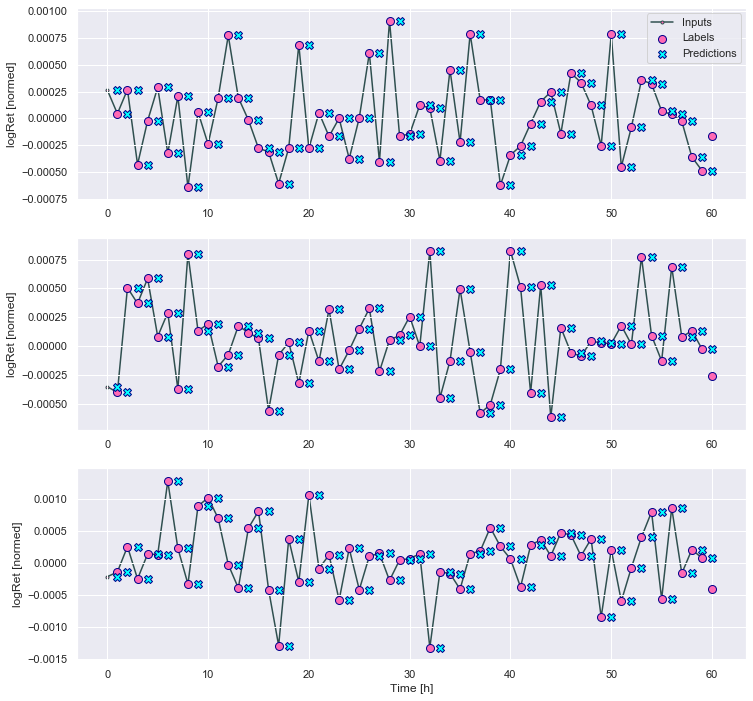

In [28]:
wide_window.plot(baseline)

In the above plots of three examples the single step model is run over the course of 1 hour. 

This can be explain as follows:

* The grey "Inputs" line shows the input log returns at each time step.
* The yellow "Labels" dots show the target prediction value. These dots are shown at the prediction time, not the input time. That is why the range of labels is shifted 1 step relative to the inputs.
* The orange "Predictions" crosses are the model's prediction's for each output time step. If the model were predicting perfectly the predictions would land directly on the "labels".

### Training procedure

I now package a training procedure into a function.

In [29]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError(), rSquared])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
    
    return history

### Linear model

In [30]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [31]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 1)
Output shape: (32, 1, 1)


In [32]:
# Train the linear model and evaluate its performance:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
875/875 [==============================] - 3s 4ms/step - loss: 2.7733e-06 - mean_absolute_error: 8.8813e-04 - rSquared: -0.6806 - val_loss: 3.2603e-06 - val_mean_absolute_error: 9.5409e-04 - val_rSquared: -0.2694
Epoch 2/20
875/875 [==============================] - 3s 3ms/step - loss: 2.0035e-06 - mean_absolute_error: 7.6670e-04 - rSquared: -0.1594 - val_loss: 2.6343e-06 - val_mean_absolute_error: 8.5523e-04 - val_rSquared: -0.0084
Epoch 3/20
875/875 [==============================] - 3s 4ms/step - loss: 1.7847e-06 - mean_absolute_error: 7.2567e-04 - rSquared: -0.0467 - val_loss: 2.5307e-06 - val_mean_absolute_error: 8.6229e-04 - val_rSquared: -0.0051
Epoch 4/20
875/875 [==============================] - 3s 3ms/step - loss: 1.7720e-06 - mean_absolute_error: 7.4029e-04 - rSquared: -0.0791 - val_loss: 2.5586e-06 - val_mean_absolute_error: 8.9281e-04 - val_rSquared: -0.0570
Epoch 5/20
250/250 [==============================] - 1s 3ms/step - loss: 2.6131e-06 - mean_absolute_err

In [33]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', baseline(wide_window.example[0]).shape)

Input shape: (32, 60, 1)
Output shape: (32, 60, 1)


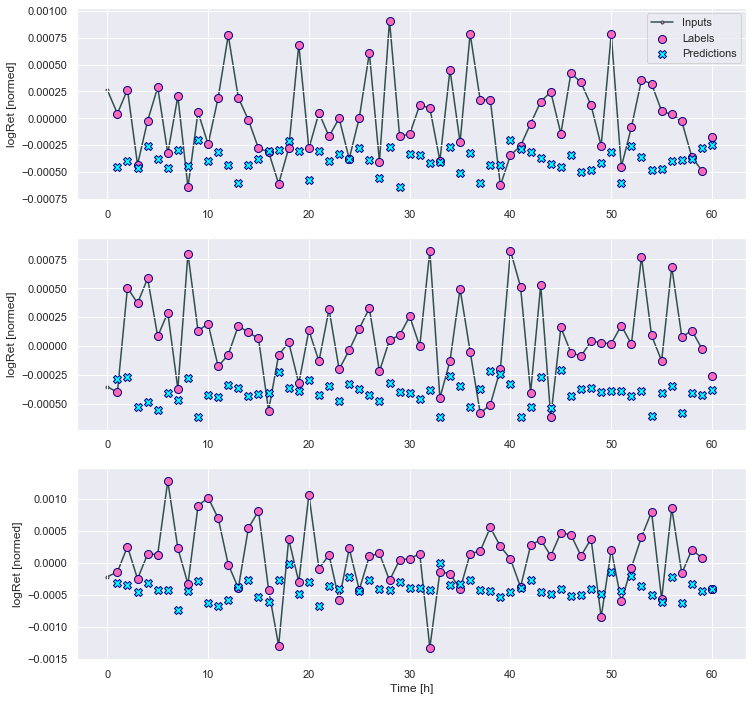

In [34]:
wide_window.plot(linear)

### Dense neural network

Here's a model similar to the linear model, except it stacks a few Dense layers between the input and the output:

In [35]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/20
875/875 [==============================] - 4s 5ms/step - loss: 2.0257e-06 - mean_absolute_error: 8.6741e-04 - rSquared: -0.3777 - val_loss: 2.6153e-06 - val_mean_absolute_error: 9.0199e-04 - val_rSquared: -0.0551
Epoch 2/20
875/875 [==============================] - 4s 5ms/step - loss: 1.8449e-06 - mean_absolute_error: 7.7335e-04 - rSquared: -0.1268 - val_loss: 2.5006e-06 - val_mean_absolute_error: 8.4650e-04 - val_rSquared: -0.0074
Epoch 3/20
875/875 [==============================] - 4s 5ms/step - loss: 1.8376e-06 - mean_absolute_error: 7.8046e-04 - rSquared: -0.1278 - val_loss: 2.5110e-06 - val_mean_absolute_error: 8.4689e-04 - val_rSquared: 0.0214
Epoch 4/20
250/250 [==============================] - 1s 3ms/step - loss: 2.5252e-06 - mean_absolute_error: 8.4256e-04 - rSquared: 0.0173


### Convolutional neural network

A convolution layer (layers.Conv1D) also takes multiple time steps as input to each prediction.

Below is the same model as multi_step_dense, re-written with a convolution.

Note the changes:

* The layers.Flatten and the first layers.Dense are replaced by a layers.Conv1D. <br>
* The layers.Reshape is no longer necessary since the convolution keeps the time axis in its output.

In [36]:
CONV_WIDTH = 60
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=60,
    shift=1,
    label_columns=['logRet'])

conv_window

Total window size: 61
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60]
Label column name(s): ['logRet']

In [37]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [38]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 60, 1)
Output shape: (32, 1, 1)


Train and evaluate it on the conv_window and it should give performance similar to the multi_step_dense model.

In [39]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

249/249 [==============================] - 1s 3ms/step - loss: 2.6968e-06 - mean_absolute_error: 8.6113e-04 - rSquared: -0.0117


The difference between this conv_model and the multi_step_dense model is that the conv_model can be run on inputs on inputs of any length. The convolutional layer is applied to a sliding window of inputs.

If you run it on wider input, it produces wider output

In [40]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 60, 1)
Labels shape: (32, 60, 1)
Output shape: (32, 1, 1)


Note that the output is shorter than the input. To make training or plotting work, you need the labels, and prediction to have the same length. So build a WindowGenerator to produce wide windows with a few extra input time steps so the label and prediction lengths match:

In [41]:
LABEL_WIDTH = 60
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['logRet'])

wide_conv_window

Total window size: 120
Input indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118]
Label indices: [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
Label column name(s): ['logRet']

In [42]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 119, 1)
Labels shape: (32, 60, 1)
Output shape: (32, 60, 1)


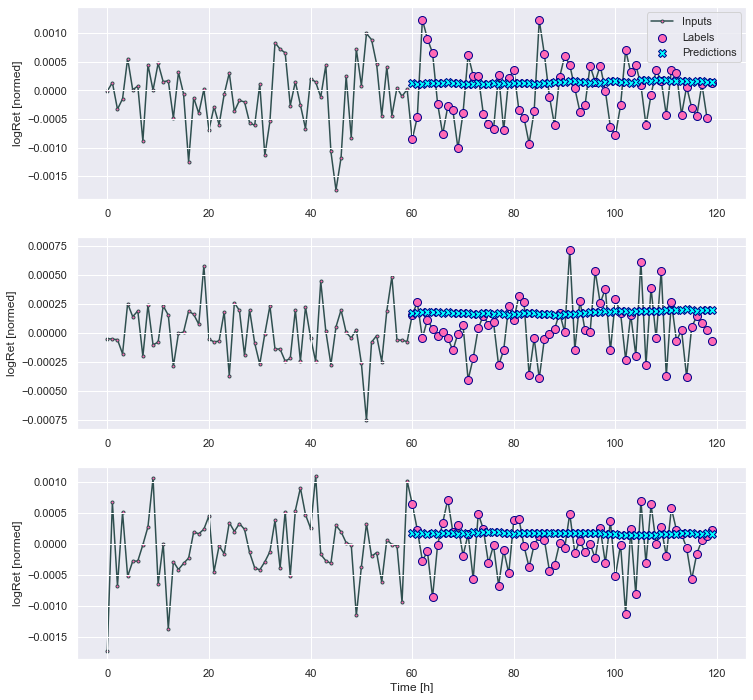

In [43]:
wide_conv_window.plot(conv_model)

### Long Short-Term Memory (LSTM) recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.  

I now introduce a RNN layer called Long Short Term Memory (LSTM).

> **ACTION |** Add diagrams and some of the further explanatory text that I have omitted from just under `Recurrent neural network`

I define a LSTM model:

In [44]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(units=1)
])

I set the constructor argument `return_sequences` to true, i.e. `return_sequences=True`, so that I train the model on 1 hour, or 60 minutes, of data at a time.

In [45]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 60, 1)
Output shape: (32, 60, 1)


In [46]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

249/249 [==============================] - 1s 4ms/step - loss: 2.3827e-06 - mean_absolute_error: 8.5290e-04 - rSquared: 0.0998


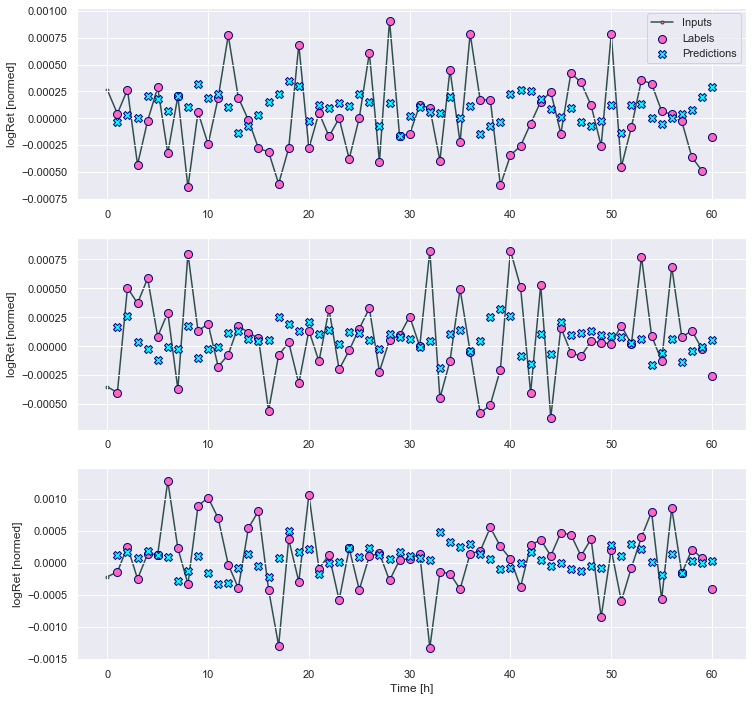

In [47]:
wide_window.plot(lstm_model)

### logRet Performance summary (1-step)

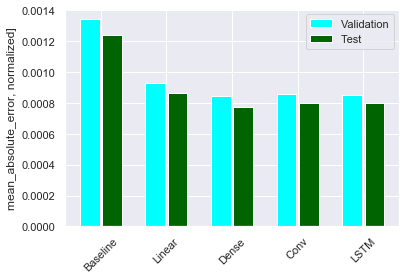

In [48]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error, normalized]')
plt.bar(x - 0.17, val_mae, width, color = 'cyan', label='Validation')
plt.bar(x + 0.17, test_mae, width, color = 'darkgreen', label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

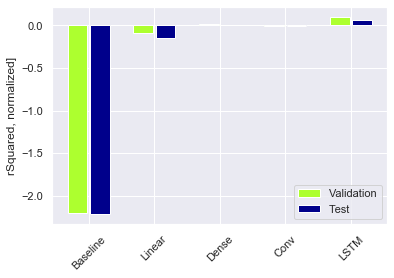

In [49]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'rSquared'
metric_index = lstm_model.metrics_names.index('rSquared')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('rSquared, normalized]')
plt.bar(x - 0.17, val_mae, width, color = 'greenyellow', label='Validation')
plt.bar(x + 0.17, test_mae, width, color = 'darkblue', label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

[The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances similar but also averaged across output timesteps** | **`IMPORTANT -- DO I WANT AVERAGES, OR THE BEST SCORE`**]

In [50]:
for name, value in performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Baseline: 0.0012
Linear  : 0.0009
Dense   : 0.0008
Conv    : 0.0008
LSTM    : 0.0008


[WORK OUT HOW TO GET THE NAME BELOW, AS ABOVE (IF I HAVE TIME)]

In [51]:
metric_name = 'rSquared'
metric_index = lstm_model.metrics_names.index('rSquared')
test_rSquared = [v[metric_index] for v in performance.values()]

for value in test_rSquared:
    print(value)
    

-2.219571828842163
-0.15100224316120148
0.0039435820654034615
-0.010648585855960846
0.06236281991004944


## n-step (i.e. multi-step) models

Both the single-output and multiple-output models in the previous sections made single time step predictions, 1h into the future.

This section looks at how to expand these models to make multiple time step predictions.

In a multi-step prediction, the model needs to learn to predict a range of future values. Thus, unlike a single step model, where only a single future point is predicted, a multi-step model predicts a sequence of the future values.

There are two rough approaches to this:

* Single shot predictions where the entire time series is predicted at once.
* Autoregressive predictions where the model only makes single step predictions and its output is fed back as its input.

In this section all the models will predict all the features across all output time steps.

For the multi-step model, the training data again consists of hourly samples. However, here, the models will learn to predict 24h of the future, given 24h of the past.

Here is a Window object that generates these slices from the dataset:

Total window size: 120
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
Label indices: [ 60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119]
Label column name(s): None

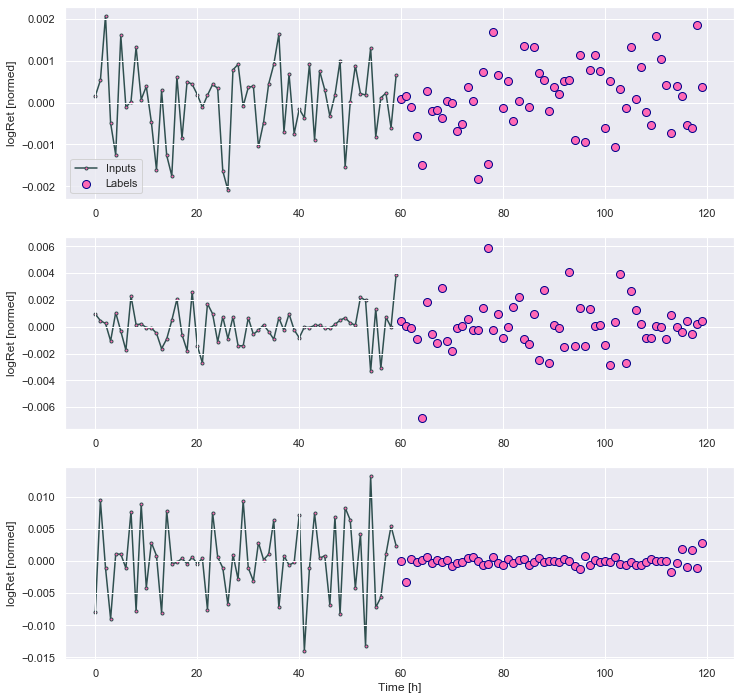

In [52]:
OUT_STEPS = 60
multi_window = WindowGenerator(input_width=60,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baseline

247/247 [==============================] - 1s 2ms/step - loss: 5.2155e-06 - mean_absolute_error: 0.0013 - rSquared: -1.0275


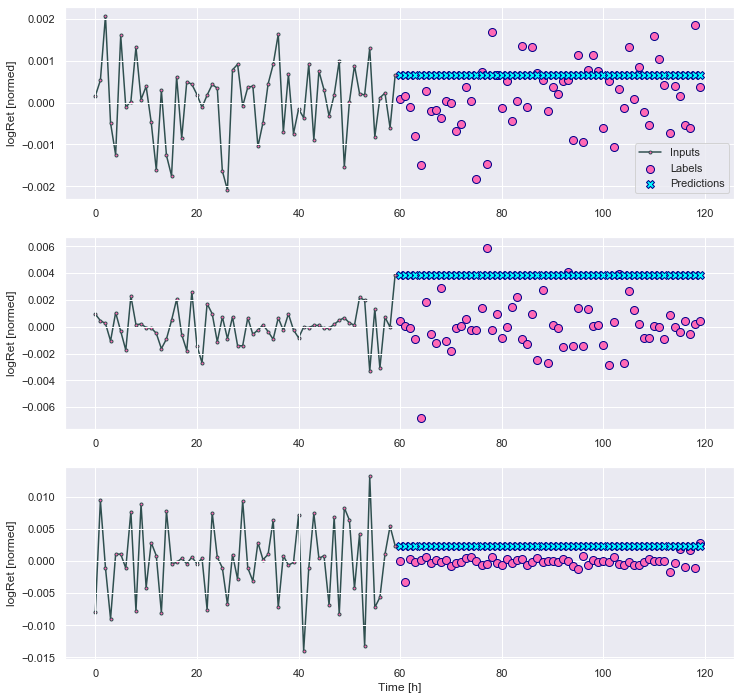

In [53]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError(), rSquared])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

### Repeat baseline

Since this task is to predict 24h given 24h another simple approach is to repeat the previous day, assuming tomorrow will be similar.

247/247 [==============================] - 1s 2ms/step - loss: 5.3523e-06 - mean_absolute_error: 0.0013 - rSquared: -1.1446


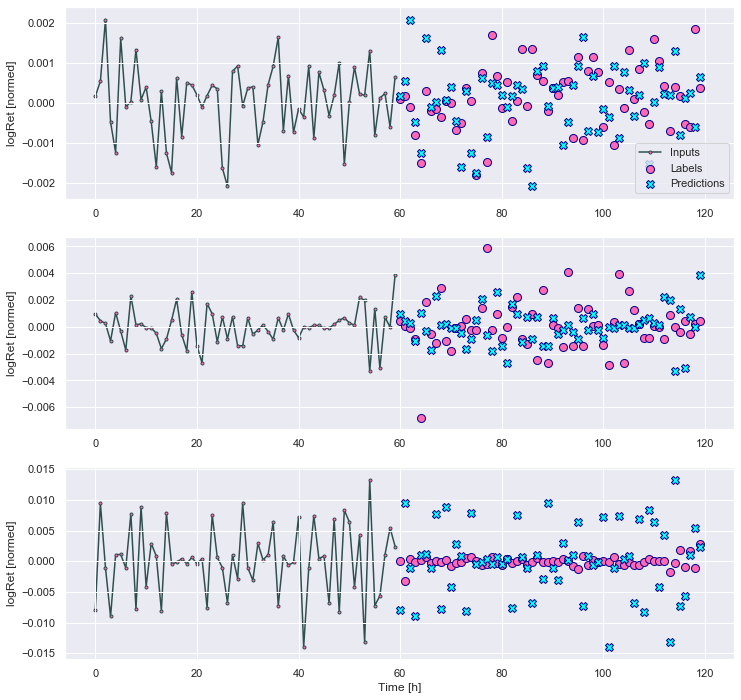

In [54]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError(), rSquared])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

## n-step | Single-shot models

One high level approach to this problem is use a "single-shot" model, where the model makes the entire sequence prediction in a single step.

This can be implemented efficiently as a layers.Dense with OUT_STEPS*features output units. The model just needs to reshape that output to the required (OUTPUT_STEPS, features).

### Linear

A simple linear model based on the last input time step does better than either baseline, but is underpowered. The model needs to predict OUTPUT_STEPS time steps, from a single input time step with a linear projection. It can only capture a low-dimensional slice of the behavior, likely based mainly on the time of day and time of year.

247/247 [==============================] - 1s 3ms/step - loss: 2.6730e-06 - mean_absolute_error: 8.8339e-04 - rSquared: -0.0374


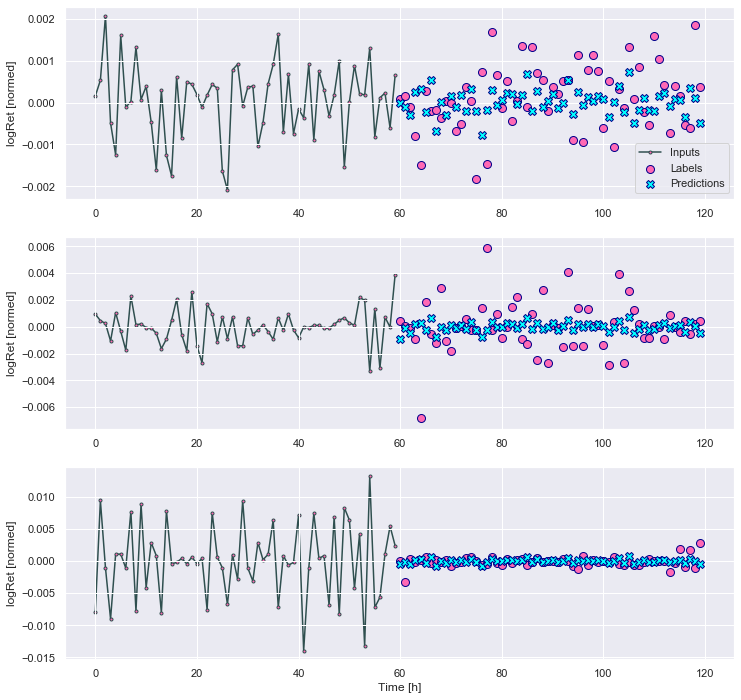

In [55]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

### Dense

Adding a layers.Dense between the input and output gives the linear model more power, but is still only based on a single input timestep.

247/247 [==============================] - 1s 3ms/step - loss: 2.6947e-06 - mean_absolute_error: 8.9405e-04 - rSquared: -0.0467


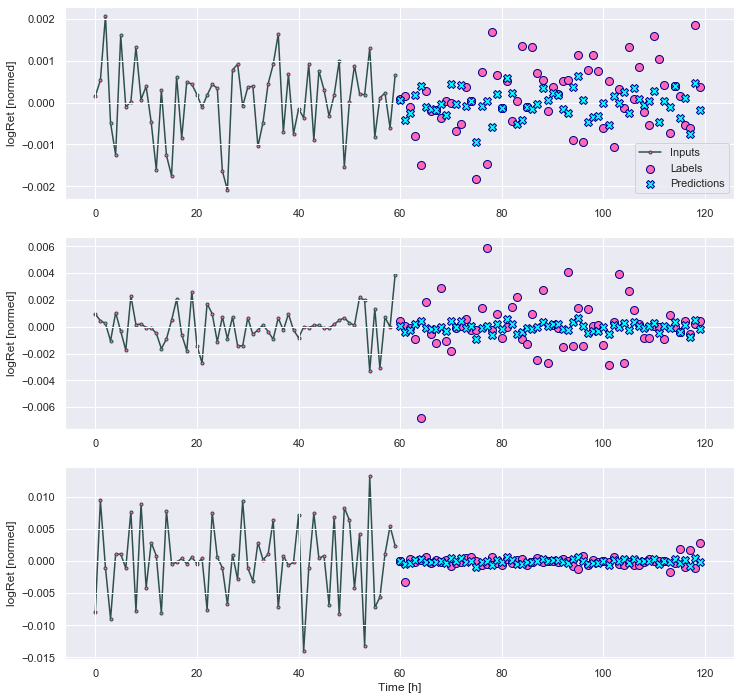

In [56]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

### Convolutional Neural Network

A convolutional model makes predictions based on a fixed-width history, which may lead to better performance than the dense model since it can see how things are changing over time:

247/247 [==============================] - 1s 3ms/step - loss: 2.6808e-06 - mean_absolute_error: 8.8609e-04 - rSquared: -0.0402


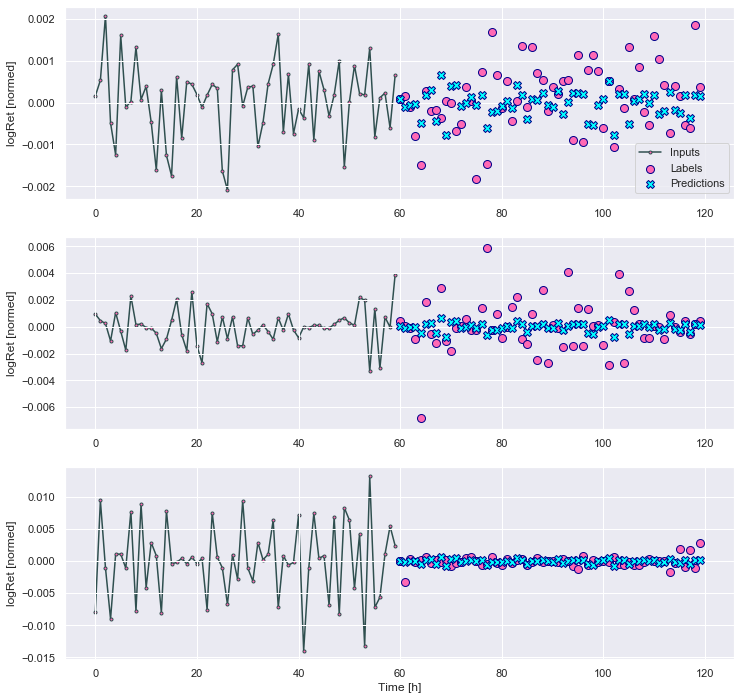

In [57]:
CONV_WIDTH = 60
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

### LSTM

A recurrent model can learn to use a long history of inputs, if it's relevant to the predictions the model is making. Here the model will accumulate internal state for 24h, before making a single prediction for the next 24h.

In this single-shot format, the LSTM only needs to produce an output at the last time step, so set return_sequences=False.

247/247 [==============================] - 1s 4ms/step - loss: 2.6719e-06 - mean_absolute_error: 8.8044e-04 - rSquared: -0.0366


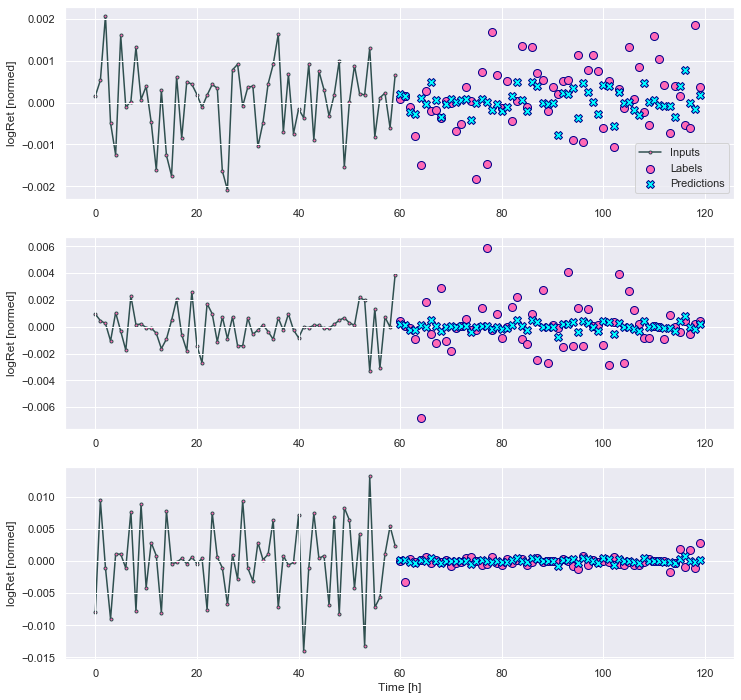

In [58]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.train, verbose=0)
multi_window.plot(multi_lstm_model)

### logRet Performance summary (n-step)

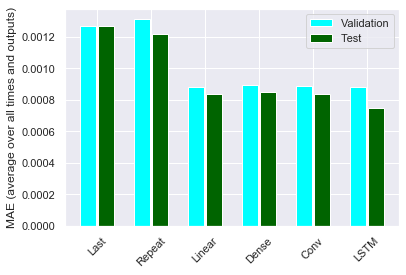

In [59]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, color = 'cyan', label='Validation')
plt.bar(x + 0.17, test_mae, width, color = 'darkgreen', label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

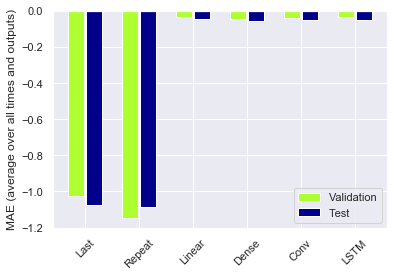

In [60]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'rSquared'
metric_index = lstm_model.metrics_names.index('rSquared')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, color = 'greenyellow', label='Validation')
plt.bar(x + 0.17, test_mae, width, color = 'darkblue', label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

[The metrics for the multi-output models in the first half of this tutorial show the performance averaged across all output features. These performances similar but also averaged across output timesteps** | **`IMPORTANT -- DO I WANT AVERAGES, OR THE BEST SCORE`**]

In [61]:
for name, value in multi_performance.items():
    print(f'{name:8s}: {value[1]:0.4f}')

Last    : 0.0013
Repeat  : 0.0012
Linear  : 0.0008
Dense   : 0.0008
Conv    : 0.0008
LSTM    : 0.0007


[WORK OUT HOW TO GET THE NAME BELOW, AS ABOVE (IF I HAVE TIME)]

In [62]:
metric_name = 'rSquared'
metric_index = lstm_model.metrics_names.index('rSquared')
test_rSquared = [v[metric_index] for v in multi_performance.values()]

for value in test_rSquared:
    print(value)
    

-1.0747627019882202
-1.0872124433517456
-0.044027458876371384
-0.057481493800878525
-0.050048649311065674
-0.05258948355913162


> * END | Model section `logRet`
***